Представьте, что вы работаете аналитиком в компании, которая занимается арендой велосипедов. Коллега из офиса в Лондоне прислал вам данные за два года: с 4 января 2015 по 3 января 2017. Вам предстоит изучить динамику числа аренд, наличие связи с погодными условиями и выходными, а также объяснить несколько аномалий на графике.

In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr

Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.

In [155]:
df = pd.read_csv('london.csv', parse_dates=['timestamp'])

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


Есть ли в данных пропущенные значения?

In [157]:
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [158]:
# df.set_index('timestamp').loc['2016-08-31':'2016-10-30'].head(50)

Для начала попробуем посмотреть на число поездок по датам и времени. Постройте график, где:

по оси x – дата (timestamp)
по оси y – число поездок (cnt)

In [159]:
df_new = df.sort_values(by='timestamp').set_index('timestamp')
df_new.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


С помощъю resample сгруппируем данные по дням

In [160]:
rent_by_days = df_new.resample(rule='D').cnt.sum()

In [161]:
type(rent_by_days)

pandas.core.series.Series

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

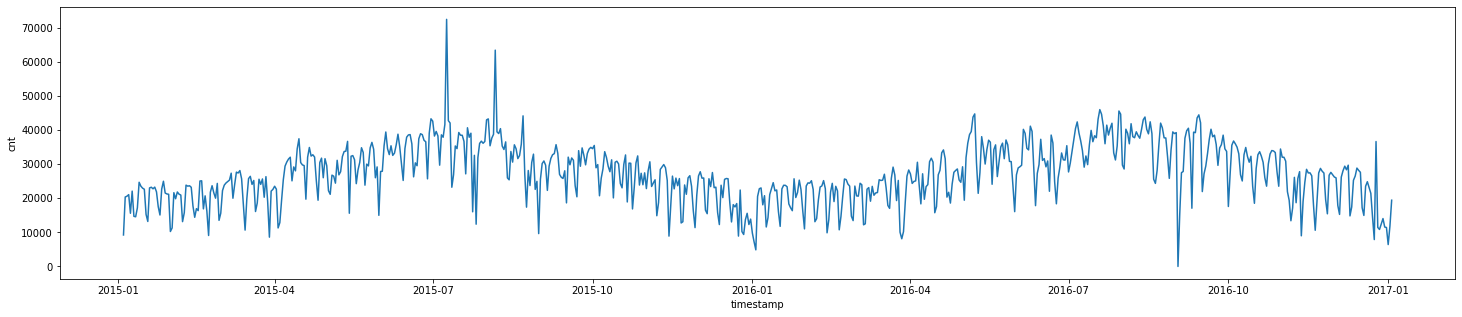

In [162]:
plt.figure(figsize=(25,5))
sns.lineplot(data=rent_by_days)

добавим 3 дневное скользящее среднее

In [163]:
rent_by_days = pd.concat([rent_by_days, rent_by_days.to_frame().rolling(3).mean()], axis=1)
rent_by_days.columns = ['cnt', 'roll_3']
rent_by_days

,cnt,roll_3
timestamp,,
2015-01-04,9234,NaN
2015-01-05,20372,NaN
2015-01-06,20613,16739.666667
2015-01-07,21064,20683.000000
2015-01-08,15601,19092.666667
...,...,...
2016-12-30,11566,12682.000000
2016-12-31,11424,12347.333333
2017-01-01,6421,9803.666667


посмотрим как это выглядит визуально

Примем за аномалии - превышение 99% доверительного интервала (2,576 стандартных отклонения)

In [164]:
# считаем стандартное отклонение
std = np.std(rent_by_days.cnt - rent_by_days.roll_3)

In [165]:
rent_by_days['upper_bound'] = rent_by_days.roll_3 + 2.576 * std
rent_by_days['lower_bound'] = rent_by_days.roll_3 - 2.576 * std
rent_by_days

,cnt,roll_3,upper_bound,lower_bound
timestamp,,,,
2015-01-04,9234,NaN,NaN,NaN
2015-01-05,20372,NaN,NaN,NaN
2015-01-06,20613,16739.666667,28482.585854,4996.747479
2015-01-07,21064,20683.000000,32425.919188,8940.080812
2015-01-08,15601,19092.666667,30835.585854,7349.747479
...,...,...,...,...
2016-12-30,11566,12682.000000,24424.919188,939.080812
2016-12-31,11424,12347.333333,24090.252521,604.414146
2017-01-01,6421,9803.666667,21546.585854,-1939.252521


<AxesSubplot:xlabel='timestamp'>

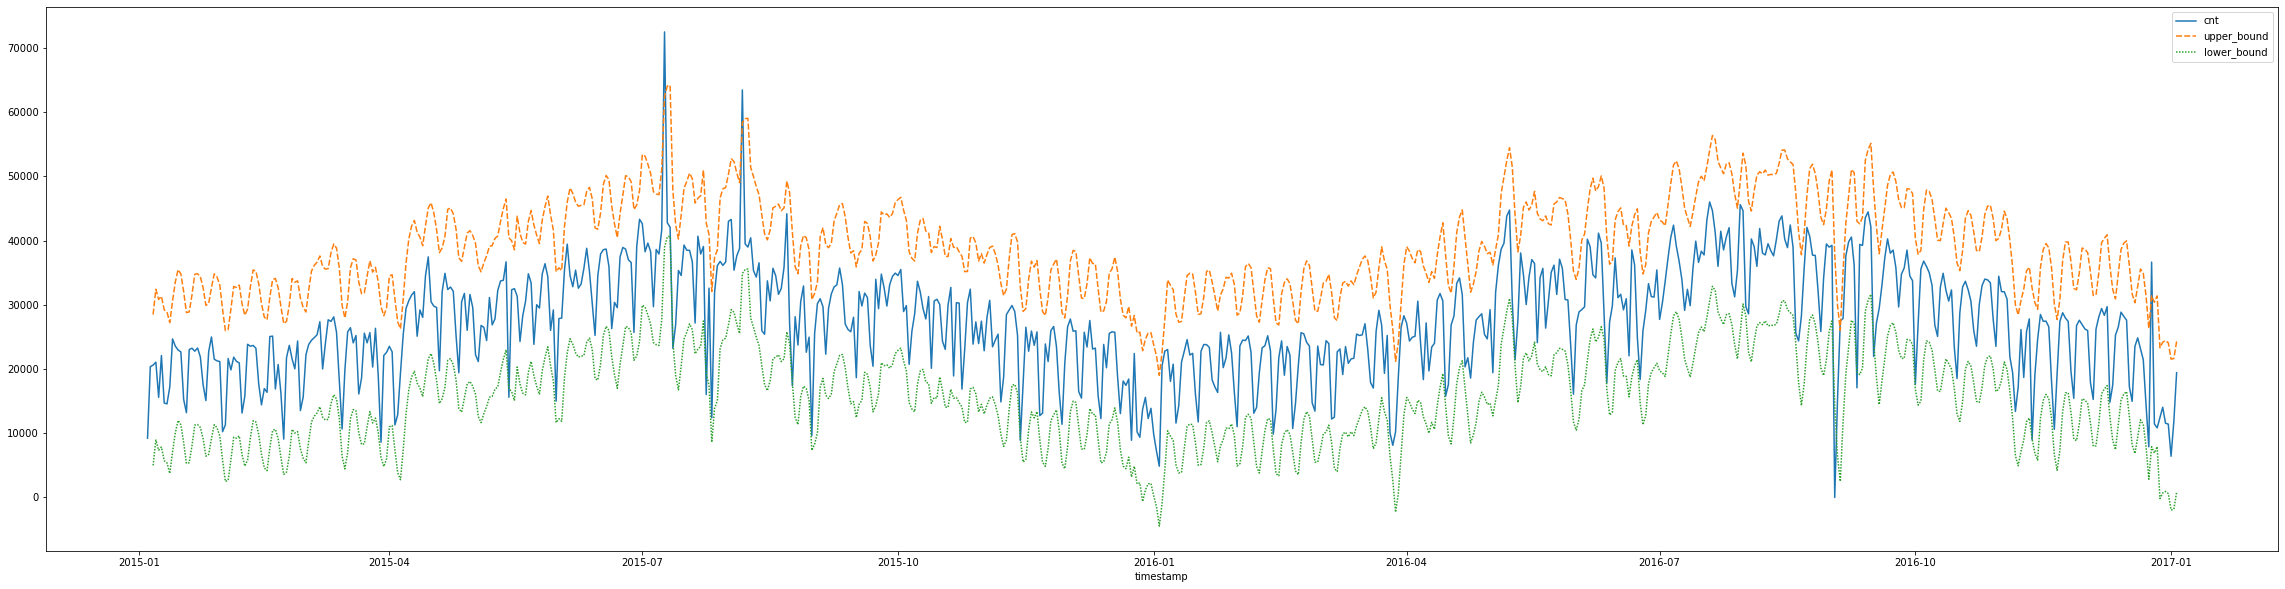

In [170]:
plt.figure(figsize=(40,10))
sns.lineplot(data=rent_by_days.drop(columns="roll_3"), legend="auto")

Посмотрим пристальней на дни, когда число аренд было ниже ожиданий.

In [167]:
rent_by_days.query('cnt < lower_bound')

,cnt,roll_3,upper_bound,lower_bound
timestamp,,,,
2015-05-14,15609,28709.333333,40452.252521,16966.414146
2015-07-12,23240,36036.666667,47779.585854,24293.747479
2015-07-24,16034,31013.666667,42756.585854,19270.747479
2015-08-24,17400,29529.333333,41272.252521,17786.414146
2015-11-14,8898,21037.333333,32780.252521,9294.414146
2016-09-02,0,26086.333333,37829.252521,14343.414146
2016-09-10,17080,31262.000000,43004.919188,19519.080812
2016-09-16,21967,36193.333333,47936.252521,24450.414146
2016-11-12,8990,20878.000000,32620.919188,9135.080812


Любопытно что произошло 2 сент. 2016г. Имеет смысл посмотреть исходные данные за этот период

In [176]:
df.set_index('timestamp').cnt.loc['2016-09-01 21:00:00':'2016-09-03 14:00:00']

timestamp
2016-09-01 21:00:00    1156
2016-09-01 22:00:00     939
2016-09-03 12:00:00    2709
2016-09-03 13:00:00    2382
2016-09-03 14:00:00    2528
Name: cnt, dtype: int64

Данных за эту дату нет. Истинная причина появления этой даты - свойство работы функции resaple. Она создает пропущенные даты с нулевыми значениями

Теперь посмотрим пристальней на дни, когда число аренд было выше ожиданий.

In [177]:
rent_by_days.query('cnt > upper_bound')

,cnt,roll_3,upper_bound,lower_bound
timestamp,,,,
2015-07-09,72504,50705.000000,62447.919188,38962.080812
2015-08-06,63468,46627.333333,58370.252521,34884.414146
2016-09-04,27512,14259.000000,26001.919188,2516.080812
2016-12-25,36653,19650.666667,31393.585854,7907.747479


Максимальное кол-во аренд приходится на 9 июля 2015г. Причина в забастовках, подробнее тут: https://www.bbc.com/russian/international/2015/07/150709_london_tube_strike